<a href="https://colab.research.google.com/github/tashir0605/SentimentSphere/blob/main/Emotion%20Through%20Text/Human_Emotion_via_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Text Emotion Detection

In [4]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
# from sklearn.model_selection import train_test_split,KFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

#Lime
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Dataset**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
dfs=pd.read_csv("text_emotion_dataset_raw.csv")

In [7]:
assert len(dfs) >= 8000, "Dataset should have at least 8000 rows for test and validation sets."

In [8]:
# First, split into train+val and test
train_val, df_test = train_test_split(dfs, test_size=0.2, random_state=42, stratify=dfs['Emotion'])

# Now split train_val into train and validation
df_train, df_val = train_test_split(train_val, test_size=0.2, random_state=42, stratify=train_val['Emotion'])


In [9]:
# Verify the sizes
print(f"Training set: {len(df_train)} rows")
print(f"Test set: {len(df_test)} rows")
print(f"Validation set: {len(df_val)} rows")

Training set: 22266 rows
Test set: 6959 rows
Validation set: 5567 rows


In [10]:

# Save the split datasets if needed
df_train.to_csv("df_train.csv", index=False)
df_test.to_csv("df_test.csv", index=False)
df_val.to_csv("df_val.csv", index=False)

In [11]:
df_train.head()

,Emotion,Text
11065,sadness,Last day off until five days straight of work.
21314,fear,Walking alone in the dark in a strange street.
15500,joy,I most joyous moment was the day I got my mark...
6665,joy,Most estate agents were overjoyed at the elect...
19365,sadness,@Hillmonious sounds solid :p that's a good mov...


In [12]:
#print the shape of the data set
print(df_train.shape)

(22266, 2)


In [13]:
#print first 5 rows
df_test.head()

,Emotion,Text
32781,fear,I'm now scared of small light green leafs bc t...
7349,sadness,been home for the past 45 min and iv been work...
24551,sadness,"Forgive and forget, gets the best of me, I car..."
8167,joy,Hahaha tomorrow my day is about to be wasted i...
26427,joy,"“Sometimes your is the source of your smile, b..."


In [14]:
#print the shape of the data set
print(df_test.shape)

(6959, 2)


In [15]:
#print first 5 rows
df_val.head()

,Emotion,Text
19409,disgust,Don't come back to me w that shit ever again.....
31962,sadness,"@csilcox32 yah it got knocked down, so my duty..."
7412,surprise,lovely birthday meal with all everyone! So muc...
5487,sadness,General Ye Jianying died.
26679,joy,@chibchenko i'll just keep it aw for myself th...


In [16]:
#print the shape of the data set
print(df_val.shape)

(5567, 2)


In [17]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

,count
Emotion,
joy,7069
sadness,4301
fear,3462
anger,2750
surprise,2600
neutral,1442
disgust,548
shame,94


In [18]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

,count
Emotion,
joy,31.747957
sadness,19.316447
fear,15.548370
anger,12.350669
surprise,11.676996
neutral,6.476242
disgust,2.461152
shame,0.422168


<Axes: xlabel='Emotion', ylabel='count'>

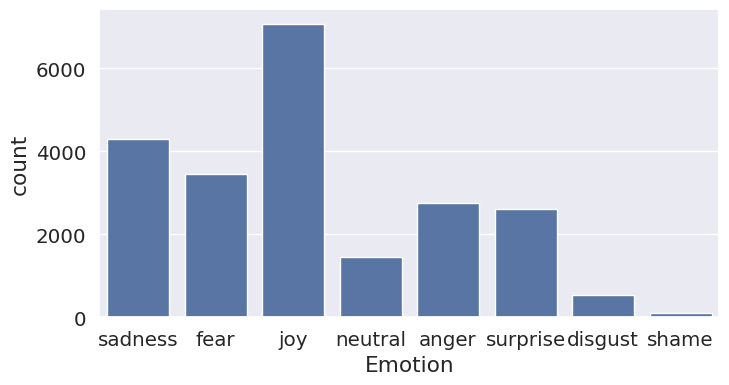

In [19]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion',data=df_train)


The provided dataset exhibits class imbalance, with certain emotion categories being more prevalent than others. While there is a possibility to address this imbalance through various techniques, it is noteworthy that the emotions of primary interest are already among the most frequently occurring. Consequently, it is currently deemed acceptable to retain the dataset in its original form, without undertaking explicit measures to rebalance the class distribution.The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [20]:
#print the number of null values in each column
df_train.isnull().sum()

,0
Emotion,0
Text,0


In [21]:
#print the number of duplicated values
df_train.duplicated().sum()

np.int64(1662)

In [22]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [23]:
df_train.shape

(20604, 2)

There is just 2301 row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [24]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Emotion,Text
4881,neutral,Wow !
5445,joy,Thank you .
6005,sadness,It's us .
6288,joy,Thanks .
6637,joy,OK .
7033,joy,Yes .
7134,joy,It sure is .
8324,joy,Bye .
9788,anger,Why not ?
9805,joy,You bet !


In [25]:
#print some rows to check
df_train[df_train['Text'] == dfs.iloc[18369]['Text']]
df_train[df_train['Text'] == dfs.iloc[10875]['Text']]
df_train[df_train['Text'] == dfs.iloc[14451]['Text']]

,Emotion,Text
4660,fear,"@_anne_so Même pour un vieux film, rien que le..."


In [26]:
# Step 1: Identify texts with conflicting emotion labels
conflicting_texts = df_train.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1].index  # Texts with >1 unique emotion

# Step 2: Remove only those conflicting texts
df_train = df_train[~df_train["Text"].isin(conflicting_texts)].copy()

# Step 3: Drop exact duplicates (same text & emotion)
df_train = df_train.drop_duplicates()

# Step 4: Print the shape after cleanup
print(df_train.shape)



(20542, 2)


In [27]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed


0


In [28]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,2459
5,2342
3,2308
6,2096
2,2076
7,1734
0,1549
1,1537
8,1347


The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty

<Axes: ylabel='Frequency'>

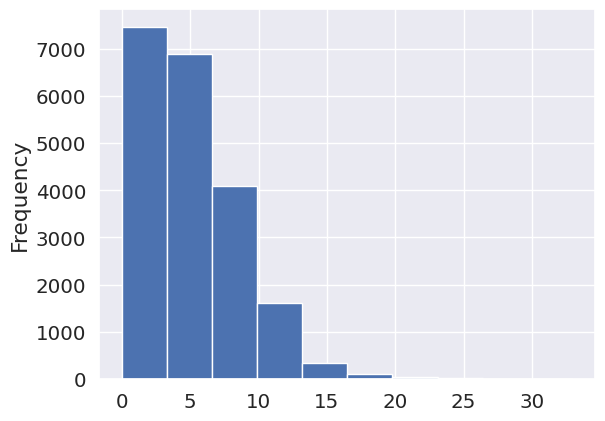

In [29]:

#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

# Test dataset

In [30]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

,count
Emotion,
joy,2209
sadness,1345
fear,1082
anger,860
surprise,812
neutral,451
disgust,171
shame,29


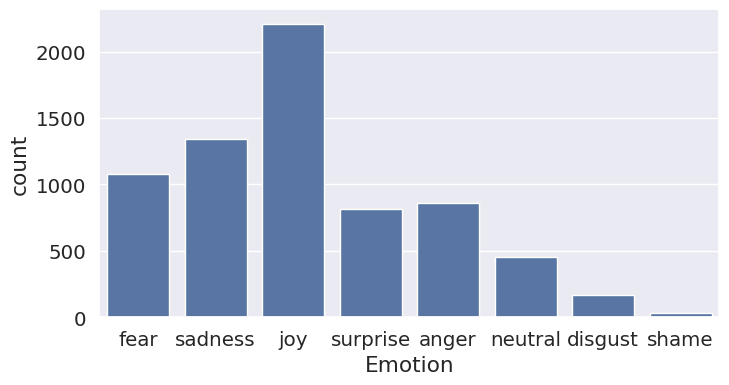

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [32]:
#print the number of null values in each column
df_test.isnull().sum()

,0
Emotion,0
Text,0


In [33]:
#print the number of duplicated values
df_test.duplicated().sum()

np.int64(271)

In [34]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
8697,neutral,Yes .
16760,fear,Strictly avoid frightening ideas
29602,neutral,Why not ?
20555,neutral,Why not ?
22487,neutral,Yes .
...,...,...
7772,sadness,"In their communiqu , the finance ministers cou..."
4443,fear,"not afraid of tomorrow, for I have seen yester..."
6911,neutral,Bye !
3907,fear,I don't need to swear to anything. Punch your ...


In [35]:
#removing duplicated values
index = df_test[df_test.duplicated() == True].index
df_test = df_test.drop_duplicates().reset_index(drop=True)



In [36]:
df_test.shape

(6688, 2)

In [37]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
1550,joy,Okay .
1572,neutral,Thanks .
2079,neutral,"Oh , no ."
2234,joy,Yes .
3185,neutral,And why are you yarning now ? Are you bored ?
5538,sadness,I don't think you really want to hear about i...
5893,anger,Certainly not .
5974,joy,OK .


In [38]:
#print some rows to check
df_test[df_test['Text'] == dfs.iloc[419]['Text']]
df_test[df_test['Text'] == dfs.iloc[729]['Text']]
df_test[df_test['Text'] == dfs.iloc[2109]['Text']]

,Emotion,Text
2317,neutral,What for ?


In [39]:
# Check which texts have conflicting emotions
conflicting_texts = df_test.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df_test[df_test["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df_test = df_test.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df_test.shape)

      Emotion                                               Text
115   neutral                                             Yes . 
635     anger     And why are you yarning now ? Are you bored ? 
844   sadness                                         Oh , no . 
1004  neutral                                              OK . 
1367  neutral                                            Okay . 
1550      joy                                            Okay . 
1571      joy                                          Thanks . 
1572  neutral                                          Thanks . 
2079  neutral                                         Oh , no . 
2234      joy                                             Yes . 
3185  neutral     And why are you yarning now ? Are you bored ? 
3249    anger   I don't think you really want to hear about i...
3352  sadness                                   Certainly not . 
5538  sadness   I don't think you really want to hear about i...
5893    anger            

In [40]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [41]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,771
5,768
3,715
2,664
6,656
7,564
0,530
1,499
8,474


<Axes: ylabel='Frequency'>

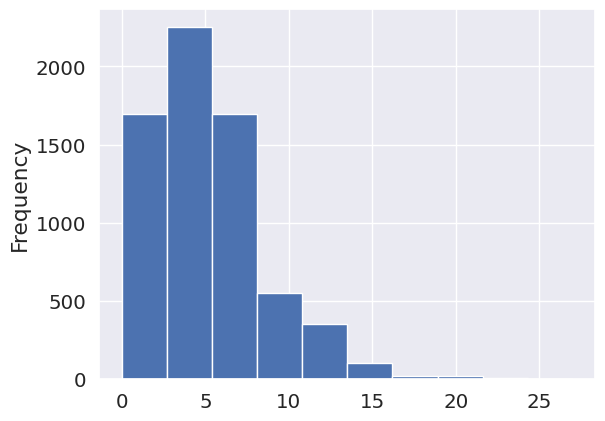

In [42]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

# Validation Dataset

In [43]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

,count
Emotion,
joy,1767
sadness,1076
fear,866
anger,687
surprise,650
neutral,361
disgust,137
shame,23


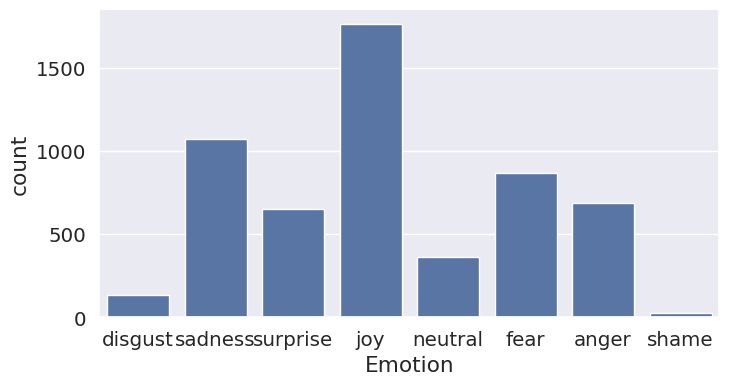

In [44]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [45]:
#print the number of null values in each column
df_val.isnull().sum()

,0
Emotion,0
Text,0


In [46]:
#print the number of duplicated values
df_val.duplicated().sum()

np.int64(206)

In [47]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
26844,neutral,Yes .
1731,neutral,Yes .
19345,fear,"For Swift , there is a connection between cosm..."
10933,neutral,Well ...
13850,fear,"not afraid of tomorrow, for I have seen yester..."
...,...,...
24489,neutral,Why not ?
3672,neutral,And ?
4228,fear,You gain and confidence by every experience ...
31462,fear,Strictly avoid frightening ideas


In [48]:
#removing duplicated values
index = df_val[df_val.duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [49]:
df_val.shape

(5361, 2)

In [50]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
1365,neutral,You ’ re right .
3613,neutral,Thank you .
3798,joy,Thank you very much .
5161,anger,Not at all .


In [51]:
# Check which texts have conflicting emotions
conflicting_texts = df_val.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df_val[df_val["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df_val = df_val.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df_val.shape)

      Emotion                     Text
1356      joy        You ’ re right . 
1365  neutral        You ’ re right . 
1399     fear   Thank you very much . 
2900      joy             Thank you . 
3613  neutral             Thank you . 
3798      joy   Thank you very much . 
4929  neutral            Not at all . 
5161    anger            Not at all . 
(5357, 2)


In [52]:
print(df_val["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [53]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

,count
stop_words,
4,676
5,623
3,569
2,563
6,508
1,440
7,427
0,426
8,336


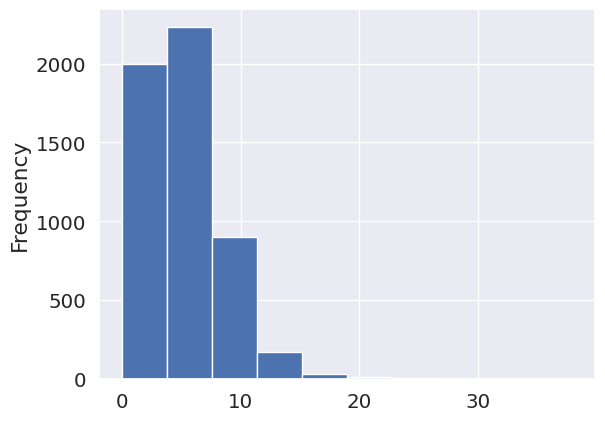

In [54]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

# Compare rows of the datasets

Check that there is no data leakage

In [55]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Use NLTK's stopword list
stop_words = set(stopwords.words('english'))

def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2, indicator=True, how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

# Preprocessing functions
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_stop_words(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def Removing_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

def lower_case(text):
    return " ".join([word.lower() for word in text.split()])

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)
    return text.strip()

def Removing_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)
    df.dropna(subset=['Text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def normalize_text(df):
    df['Text'] = df['Text'].apply(lower_case)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(Removing_numbers)
    df['Text'] = df['Text'].apply(Removing_punctuations)
    df['Text'] = df['Text'].apply(Removing_urls)
    df['Text'] = df['Text'].apply(lemmatization)
    df = remove_small_sentences(df)
    df.reset_index(drop=True, inplace=True)
    return df

def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = Removing_numbers(sentence)
    sentence = Removing_punctuations(sentence)
    sentence = Removing_urls(sentence)
    sentence = lemmatization(sentence)
    return sentence

# Example test sentence
print(normalized_sentence("My Name is _Maysaa. @Tweets,  "))

# Normalize the datasets
df_train = normalize_text(df_train)
df_test = normalize_text(df_test)
df_val = normalize_text(df_val)

# Remove overlaps to ensure clean splits
df_test = df_test[~df_test['Text'].isin(df_train['Text'])]
df_val = df_val[~df_val['Text'].isin(df_train['Text'])]
df_val = df_val[~df_val['Text'].isin(df_test['Text'])]

# Reset index after filtering
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Assert no data leakage between datasets
assert len(set(df_train['Text']).intersection(df_test['Text'])) == 0, "Train-Test leakage detected!"
assert len(set(df_train['Text']).intersection(df_val['Text'])) == 0, "Train-Val leakage detected!"
assert len(set(df_test['Text']).intersection(df_val['Text'])) == 0, "Test-Val leakage detected!"

# Optional: Print overlaps
print("Train-Test overlap:")
print(dataframe_difference(df_train, df_test, which='both'))

print("Train-Val overlap:")
print(dataframe_difference(df_train, df_val, which='both'))

print("Val-Test overlap:")
print(dataframe_difference(df_val, df_test, which='both'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


name maysaa tweet
Train-Test overlap:
Empty DataFrame
Columns: [Emotion, Text, _merge]
Index: []
Train-Val overlap:
Empty DataFrame
Columns: [Emotion, Text, _merge]
Index: []
Val-Test overlap:
Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []


In [56]:
# dataframe_difference(df_train, df_test, which='both')
# dataframe_difference(df_train, df_val, which='both')
# dataframe_difference(df_val, df_test, which='both')

# Cleaning

In [57]:
# nltk.download('wordnet')

In [58]:
# def lemmatization(text):
#     lemmatizer= WordNetLemmatizer()

#     text = text.split()

#     text=[lemmatizer.lemmatize(y) for y in text]

#     return " " .join(text)

# def remove_stop_words(text):

#     Text=[i for i in str(text).split() if i not in stop_words]
#     return " ".join(Text)

# def Removing_numbers(text):
#     text=''.join([i for i in text if not i.isdigit()])
#     return text

# def lower_case(text):

#     text = text.split()

#     text=[y.lower() for y in text]

#     return " " .join(text)

# def Removing_punctuations(text):
#     ## Remove punctuations
#     text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
#     text = text.replace('؛',"", )

#     ## remove extra whitespace
#     text = re.sub('\s+', ' ', text)
#     text =  " ".join(text.split())
#     return text.strip()

# def Removing_urls(text):
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     return url_pattern.sub(r'', text)

# def remove_small_sentences(df):
#     for i in range(len(df)):
#         if len(df.text.iloc[i].split()) < 3:
#             df.text.iloc[i] = np.nan

# def normalize_text(df):
#     df.Text=df.Text.apply(lambda text : lower_case(text))
#     df.Text=df.Text.apply(lambda text : remove_stop_words(text))
#     df.Text=df.Text.apply(lambda text : Removing_numbers(text))
#     df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
#     df.Text=df.Text.apply(lambda text : Removing_urls(text))
#     df.Text=df.Text.apply(lambda text : lemmatization(text))
#     return df

# def normalized_sentence(sentence):
#     sentence= lower_case(sentence)
#     sentence= remove_stop_words(sentence)
#     sentence= Removing_numbers(sentence)
#     sentence= Removing_punctuations(sentence)
#     sentence= Removing_urls(sentence)
#     sentence= lemmatization(sentence)
#     return sentence

In [59]:
# normalized_sentence("My Name is _Maysaa. @Tweets,  ")

In [60]:
# df_train= normalize_text(df_train)
# df_test= normalize_text(df_test)
# df_val= normalize_text(df_val)

In [61]:
# # ✅ Assertions to ensure there's no overlap (data leakage check)
# assert dataframe_difference(df_train, df_test, 'both').empty, "Train and Test have overlapping samples!"
# assert dataframe_difference(df_train, df_val, 'both').empty, "Train and Validation have overlapping samples!"
# assert dataframe_difference(df_val, df_test, 'both').empty, "Validation and Test have overlapping samples!"

# Modeling

TF-IDF (Term Frequency - Inverse Document Frequency) is a technique used to address certain issues associated with word counts. In traditional word counts, the most frequently occurring words, including common stop words, are given significant attention despite their lack of importance.

TF-IDF adjusts these word counts by considering two factors:

1. Term Frequency (TF): This measures the frequency of a term within a specific document. It assigns higher weight to words that appear more frequently in the document.

2. Inverse Document Frequency (IDF): This measures the rarity of a term across all documents in a corpus. It assigns higher weight to words that are relatively rare across the entire collection of documents.

By combining TF and IDF, TF-IDF aims to give more importance to words that are both rare across all documents (high IDF) and appear frequently within a specific document (high TF). This approach helps highlight terms that are distinctive to a particular document.

In TF-IDF, if a word appears only in the current document or sentence, it will have a TF-IDF value of 1. If a word appears in all documents or sentences except the current one, it will have a TF-IDF value of 0. For words that are common across both the current document and all others, their TF (count) will be high, but the IDF (discount) will be even higher, resulting in a lower overall TF-IDF value.

This way, TF-IDF offers a more nuanced representation of word importance by considering both the local importance within a document (TF) and the global rarity across all documents (IDF).

**Data pre-processing**

In Natural Language Processing (NLP), **neattext** refers to a Python library designed to provides a set of simple and easy-to-use functions for cleaning, formatting, and processing text data.

**Some of the common functionalities offered by the neattext library include:**

1. Removing special characters and unwanted symbols

2. Normalization: This includes tasks like converting text to lowercase, expanding contractions (e.g., changing "I'm" to "I am"), and removing stopwords (common words like "the", "is", etc. that don’t add much meaning in NLP tasks).

3. Handling tokenization: neattext can tokenize a given sentence into words, which is useful for many downstream NLP tasks.

4. Text formatting: It provides tools for removing extra whitespaces, line breaks, and formatting issues.

In [62]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [63]:
def train_model(model, data, targets):

    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [64]:
def get_F1(trained_model,X,y):

    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

# Better

**Text Preprocessing**

In [65]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [66]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [67]:
#print the labels after encoding
print(set(y_train))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}


In [68]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

**Tokenization**

In [69]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))#

In [70]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

25245

In [71]:
#print the index of a single word
tokenizer.word_index['towards']

693

In [72]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[40], [3], [833], [3], [834], [16]]

In [73]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
#the sentence contains three words and the size of the vocabulary is 31649
tokenizer.texts_to_matrix(X_train[0].split()).shape

(6, 30760)

In [75]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# Padding


The vectors we obtain are generally not of equal lengths


For that, we might need to pad the sequences to max len.

In [76]:
df_test.shape

(5680, 2)

In [77]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

368

In [78]:
X_train = pad_sequences(sequences_train, maxlen=631, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=631, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=631, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 30760


In [79]:
#before
sequences_train[0]

[40, 3, 833, 3, 834, 16]

In [80]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [81]:
print(y_train)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


# Word Embedding

This code defines the following variables:

path_to_glove_file: The file path to the GloVe word vectors file.

num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.

embedding_dim: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

hits: A counter for the number of words that are found in the embeddings_index dictionary.

misses: A counter for the number of words that are not found in the embeddings_index dictionary.

embeddings_index: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [82]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove/


--2025-06-02 12:58:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-02 12:58:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-02 12:58:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [83]:
path_to_glove_file = "glove/glove.6B.200d.txt"


In [84]:

num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

In this code snippet, an embedding matrix is initialized with all zero values. The aim is to assign word vectors to the corresponding rows of the embedding matrix using a loop through the vocabulary defined by the tokenizer object.


The embedding matrix has a size of num_tokens rows and embedding_dim columns. The num_tokens represents the size of the vocabulary, and embedding_dim refers to the dimensionality of the word vectors.


For each word in the vocabulary, the code checks if it exists in the embeddings_index dictionary. If the word is found, its corresponding word vector is retrieved from the embeddings_index dictionary and assigned to the respective row in the embedding matrix. On the other hand, if the word is not found in the embeddings_index dictionary, the row in the embedding matrix remains all zeros.


During this process, two counters are maintained: hits and misses. The hits counter is incremented every time a word is successfully assigned a word vector from the embeddings_index dictionary. Conversely, the misses counter is incremented when a word is not found in the embeddings_index dictionary.


Finally, the code prints out the number of words that were successfully converted (hits) and the number of words that were not found in the embeddings_index dictionary (misses). This provides insights into the coverage of word vectors in the embeddings_index dictionary for the given vocabulary.

In [85]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 19912 words (10847 misses)


# Modeling¶


**The model consists of several layers:**

An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [86]:
from tensorflow.keras import Input
adam = Adam(learning_rate=0.005)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Embedding(vocabSize, 200, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 631, 200)       │     6,152,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 631, 512)       │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 631, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,140,616 (31.05 MB)

 Trainable params: 1,988,616 (7.59 MB)

 Non-trainable params: 6,152,000 (23.47 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],verbose=1
)


Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1823s 12s/step - accuracy: 0.3775 - loss: 1.6158 - val_accuracy: 0.4163 - val_loss: 1.5636
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1815s 12s/step - accuracy: 0.4392 - loss: 1.5197 - val_accuracy: 0.4987 - val_loss: 1.3827
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1801s 12s/step - accuracy: 0.5224 - loss: 1.3368 - val_accuracy: 0.5285 - val_loss: 1.3168
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1787s 12s/step - accuracy: 0.5550 - loss: 1.2483 - val_accuracy: 0.5551 - val_loss: 1.2455
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1770s 12s/step - accuracy: 0.5886 - loss: 1.1409 - val_accuracy: 0.5725 - val_loss: 1.1886
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1821s 12s/step - accuracy: 0.6176 - loss: 1.0680 - val_accuracy: 0.5709 - val_loss: 1.1950
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1836s 12s/step - accuracy: 0.6363 - loss: 1.0006 - val_accuracy: 0.5899 - val_loss: 1.1593
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1832s 12s/step - accuracy: 0.6706 - loss: 0

In [ ]:
# !pip install neattext


In [ ]:
# import neattext.functions as nfx

**User handles** in this case are references to social media usernames, which typically begin with an "@" symbol (e.g., @username).

In [ ]:
# df['Clean_Text']=df['Text'].apply(nfx.remove_userhandles)

In [ ]:
# df

Code to see the Functions under neattext

In [ ]:
# dir(nfx)

In [ ]:
# # Remove the Stopwords
# df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_stopwords)

In [ ]:
# df

**Splitting data into input variables and target variable**

**x**: Features are the attributes and variables extracted from the dataset. These extracted features are used as inputs to the model during training.

**y**: Labels are the output or the target variable.

In [ ]:
# x=df['Clean_Text']
# y=df['Emotion']

**Splitting data into train and test set**

We need to split our dataset into a train set and test set. The model will learn from the train set. We will use the test set to evaluate the model performance and measure the model’s knowledge capability.

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

**Training the Model**

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

In [ ]:
# pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
# pipe_lr.fit(x_train,y_train)
# pipe_lr.score(x_test,y_test)

In [ ]:
# pipe_svm = Pipeline(steps=[('cv',CountVectorizer()),('svc', SVC(kernel = 'rbf', C = 10))])
# pipe_svm.fit(x_train,y_train)
# pipe_svm.score(x_test,y_test)

In [ ]:
# pipe_rf = Pipeline(steps=[('cv',CountVectorizer()),('rf', RandomForestClassifier(n_estimators=10))])
# pipe_rf.fit(x_train,y_train)
# pipe_rf.score(x_test,y_test)

In [ ]:
# import joblib
# pipeline_file = open("text_emotion.pkl","wb")
# joblib.dump(pipe_lr,pipeline_file)
# pipeline_file.close()